In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import sys
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

In [2]:
# 예측할 종목은 한양증권(001750) 입니다
# 기간은 00-01-04 ~ 21-02-05 입니다
# Yahoo Finanace에서 다운로드 받습니다 
# null값과 0값을 제거한 데이터를 사용합니다


df = pd.read_csv('C:\Jupyter_Project\HS_50_50_150.csv')
df = df.dropna()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-02-04,9140,9150,9020,9110,9110,30886
1,2020-02-05,9200,9200,9000,9040,9040,38531
2,2020-02-06,9140,9140,8760,8920,8920,92807
3,2020-02-07,8940,8940,8750,8860,8860,49339
4,2020-02-10,8860,8920,8650,8730,8730,29151


In [3]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
245,2021-02-01,9200,9480,9100,9380,9380,81355
246,2021-02-02,9460,9810,9460,9700,9700,105755
247,2021-02-03,9850,10200,9800,9990,9990,170966
248,2021-02-04,10100,10200,9940,10150,10150,133504
249,2021-02-05,10200,10800,10150,10650,10650,251300


In [4]:
# OHLC를 Adj OHLC로 바꾸기 위한 비율입니다
# Adj OHLC는 과거의 절대가격을 현재 가격의 시점으로 보기위한 수정된 가격입니다
# 과거 발생한 액면분할과 현금배당을 반영한 Adj Close를 기준으로 조정합니다

ratio = df['Adj Close']/df['Close']
ratio

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
245    1.0
246    1.0
247    1.0
248    1.0
249    1.0
Length: 250, dtype: float64

In [5]:
df['Adj Open'] = df['Open']*ratio
df['Adj High'] = df['High']*ratio
df['Adj Low'] = df['Low']*ratio

In [6]:
df.drop(['Open','High','Low','Close'], axis=1, inplace=True)

In [7]:
df.rename(columns={'Adj Open':'Open', 'Adj High':'High', 'Adj Low':'Low', 'Adj Close':'Close'}, inplace=True)

In [8]:
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]

df

,Open,High,Low,Close,Volume
0,9140.0,9150.0,9020.0,9110,30886
1,9200.0,9200.0,9000.0,9040,38531
2,9140.0,9140.0,8760.0,8920,92807
3,8940.0,8940.0,8750.0,8860,49339
4,8860.0,8920.0,8650.0,8730,29151
...,...,...,...,...,...
245,9200.0,9480.0,9100.0,9380,81355
246,9460.0,9810.0,9460.0,9700,105755
247,9850.0,10200.0,9800.0,9990,170966
248,10100.0,10200.0,9940.0,10150,133504


In [9]:
scaler = MinMaxScaler()
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
df_scaled = scaler.fit_transform(df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

print(df_scaled)

         Open      High       Low   Close    Volume
0    0.775947  0.732143  0.804159  0.7536  0.008378
1    0.785832  0.740260  0.800693  0.7424  0.011118
2    0.775947  0.730519  0.759099  0.7232  0.030576
3    0.742998  0.698052  0.757366  0.7136  0.014993
4    0.729819  0.694805  0.740035  0.6928  0.007756
..        ...       ...       ...     ...       ...
245  0.785832  0.785714  0.818024  0.7968  0.026470
246  0.828666  0.839286  0.880416  0.8480  0.035218
247  0.892916  0.902597  0.939341  0.8944  0.058595
248  0.934102  0.902597  0.963605  0.9200  0.045165
249  0.950577  1.000000  1.000000  1.0000  0.087394

[250 rows x 5 columns]


In [10]:
# 20일 학습하고 그 다음날 종가예측
# 테스트 기간은 21일, 따라서 5299-21 : train / 21 : test

window_size = 20
TEST_SIZE = 50

In [11]:
train = df_scaled[:-TEST_SIZE]
test = df_scaled[-TEST_SIZE:]

In [12]:
test.describe()

,Open,High,Low,Close,Volume
count,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.860099,0.836234,0.890711,0.840928,0.029913
std,0.048146,0.054000,0.046308,0.049635,0.025879
min,0.774300,0.735390,0.805893,0.752000,0.004691
25%,0.831137,0.800325,0.861785,0.813600,0.013071
50%,0.857496,0.831981,0.887348,0.834400,0.019257
75%,0.892916,0.865260,0.923744,0.870400,0.040130
max,1.000000,1.000000,1.000000,1.000000,0.137986


In [13]:
# 정해진 window_size에 기반하여 20일 기간의 데이터 셋을 묶어준다

def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [14]:
from sklearn.model_selection import train_test_split

feature_cols = ['Open', 'High', 'Low', 'Volume']
label_cols = ['Close']

train_feature = train[feature_cols]
train_label = train[label_cols]

# train dataset
train_feature, train_label = make_dataset(train_feature, train_label, 20)

# train set : 모델을 학습하는 유일한 dataset
# validation set : 학습이 이미 완료된 모델을 검증하기 위한 dataset(비율 0.2) 

x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.25)

x_train.shape, x_valid.shape
# ((4206, 20, 4), (1052, 20, 4))

# test dataset : 학습과 검증이 완료된 모델의 성능을 평가하기 위한 dataset
x_test = test[feature_cols]
y_test = test[label_cols]

x_test.shape, y_test.shape
#     (21, 4),          (21, 1)  

((50, 4), (50, 1))

In [15]:
x_test, y_test = make_dataset(x_test, y_test, 20)

x_test.shape, y_test.shape
# (21-20, 20, 4),     (21-20, 1)

((30, 20, 4), (30, 1))

In [16]:
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape, x_test.shape, y_test.shape

((135, 20, 4), (45, 20, 4), (135, 1), (45, 1), (30, 20, 4), (30, 1))

In [17]:
# print proportions
print('train: {}% | validation: {}% | test {}%'.format(round(len(y_train)/len(df_scaled),2),
                                                       round(len(y_valid)/len(df_scaled),2),
                                                       round(len(y_test)/len(df_scaled),2)))

train: 0.54% | validation: 0.18% | test 0.12%


#  LSTM 모델을 변화시키며 실험

In [18]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(20, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )
model.add(Dense(1))

# BATCH size를 변화시키며 실험

In [ ]:
# val_loss가 10회 같을 시 early_stop, batch_size(=K)는 K문제 풀고 답보고 하는 식
# 위에서 모델을 구성한 후 compile 메서드를 호출하여 학습과정을 설정합니다
# optimizer : 훈련 과정을 설정한다
# loss : 최적화 과정에서 최소화될 손실 함수(loss function)을 설정합니다
# metrics : 훈련을 모니터링하기 위해 사용됩니다
# validation_data = 검증 데이터를 사용합니다. 각 에포크마다 정확도도 함께 출력됩니다
# 이 정확도는 훈련이 잘 되고 있는지를 보여줄 뿐이며 실제로 모델이 검증데이터를 학습하지는 않습니다
# 검증 데이터의 loss가 낮아지다가 높아지기 시작하면 overfitting의 신호입니다
# verbose / 0 : 출력 없음 / 1 : 훈련 진행도 보여주는 진행 막대 보여줌 / 2 : 미니 배치마다 손실 정보 출력

from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K

def RMSE(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def soft_acc(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

def MPE(y_true, y_pred): 
    return K.mean((y_true - y_pred) / y_true) * 100
    
def MSLE(y_true, y_pred):
    return K.mean(K.square(K.log(y_true+1) - K.log(y_pred+1)), axis=-1)

def RMSLE(y_true, y_pred):
    return K.sqrt(K.mean(K.square(K.log(y_true+1) - K.log(y_pred+1)), axis=-1))

def R2(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return ( 1 - SS_res/(SS_tot + K.epsilon()))
    
model.compile(loss = RMSE, optimizer='adam', metrics=[soft_acc, 'mse', 'mae', RMSE, 'mape', MPE, MSLE, RMSLE, R2])

early_stop = EarlyStopping(monitor='val_loss', patience=10)
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                    epochs=200, 
                    batch_size=64,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint])

# score_test를 만들면 테스트가 더이상 테스트가 아니고, 처음부터 모든 데이터에 대해 학습한 것과 같기 때문에 일반화 할 수 없는 모델을 만드는 것과 같다.


score_train = model.evaluate(x_train, y_train, batch_size=2)
score_validation = model.evaluate(x_valid, y_valid, batch_size=2)


Epoch 1/200
3/3 [==============================] - 2s 312ms/step - loss: 0.6382 - soft_acc: 0.4464 - mse: 0.4080 - mae: 0.5913 - RMSE: 0.6291 - mape: 105644.6406 - MPE: inf - MSLE: 0.2618 - RMSLE: 0.4804 - R2: -7.8279 - val_loss: 0.5737 - val_soft_acc: 0.5556 - val_mse: 0.3292 - val_mae: 0.5342 - val_RMSE: 0.5737 - val_mape: 104.6526 - val_MPE: 104.6526 - val_MSLE: 0.2040 - val_RMSLE: 0.4280 - val_R2: -7.1711

Epoch 00001: val_loss improved from inf to 0.57373, saving model to tmp\ckeckpointer.ckpt


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


Epoch 2/200
3/3 [==============================] - 0s 42ms/step - loss: 0.5861 - soft_acc: 0.4696 - mse: 0.3440 - mae: 0.5429 - RMSE: 0.5709 - mape: 128104.0679 - MPE: -inf - MSLE: 0.2087 - RMSLE: 0.4294 - R2: -6.6792 - val_loss: 0.5238 - val_soft_acc: 0.5556 - val_mse: 0.2743 - val_mae: 0.4862 - val_RMSE: 0.5238 - val_mape: 94.5994 - val_MPE: 94.5994 - val_MSLE: 0.1612 - val_RMSLE: 0.3799 - val_R2: -5.8097

Epoch 00002: val_loss improved from 0.57373 to 0.52376, saving model to tmp\ckeckpointer.ckpt


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


Epoch 3/200
3/3 [==============================] - 0s 37ms/step - loss: 0.5319 - soft_acc: 0.4735 - mse: 0.2832 - mae: 0.4864 - RMSE: 0.5259 - mape: 278703.6337 - MPE: -inf - MSLE: 0.1620 - RMSLE: 0.3742 - R2: -5.7018 - val_loss: 0.4710 - val_soft_acc: 0.5556 - val_mse: 0.2218 - val_mae: 0.4356 - val_RMSE: 0.4710 - val_mape: 84.0266 - val_MPE: 84.0266 - val_MSLE: 0.1236 - val_RMSLE: 0.3318 - val_R2: -4.5059

Epoch 00003: val_loss improved from 0.52376 to 0.47095, saving model to tmp\ckeckpointer.ckpt


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


Epoch 4/200
3/3 [==============================] - 0s 46ms/step - loss: 0.4712 - soft_acc: 0.4891 - mse: 0.2221 - mae: 0.4299 - RMSE: 0.4626 - mape: 652264.0156 - MPE: -inf - MSLE: 0.1202 - RMSLE: 0.3227 - R2: -3.6153 - val_loss: 0.4146 - val_soft_acc: 0.5556 - val_mse: 0.1719 - val_mae: 0.3815 - val_RMSE: 0.4146 - val_mape: 72.7340 - val_MPE: 72.7340 - val_MSLE: 0.0908 - val_RMSLE: 0.2832 - val_R2: -3.2672

Epoch 00004: val_loss improved from 0.47095 to 0.41461, saving model to tmp\ckeckpointer.ckpt


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


Epoch 5/200
3/3 [==============================] - 0s 41ms/step - loss: 0.4140 - soft_acc: 0.3965 - mse: 0.1721 - mae: 0.3763 - RMSE: 0.4220 - mape: 634114.1798 - MPE: -inf - MSLE: 0.0878 - RMSLE: 0.2745 - R2: -17.9680 - val_loss: 0.3520 - val_soft_acc: 0.5556 - val_mse: 0.1239 - val_mae: 0.3215 - val_RMSE: 0.3520 - val_mape: 60.5751 - val_MPE: 60.1963 - val_MSLE: 0.0619 - val_RMSLE: 0.2322 - val_R2: -2.0752

Epoch 00005: val_loss improved from 0.41461 to 0.35197, saving model to tmp\ckeckpointer.ckpt


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


Epoch 6/200
3/3 [==============================] - 0s 42ms/step - loss: 0.3426 - soft_acc: 0.4930 - mse: 0.1175 - mae: 0.3112 - RMSE: 0.3350 - mape: 607569.0018 - MPE: -inf - MSLE: 0.0567 - RMSLE: 0.2212 - R2: -1.2795 - val_loss: 0.2743 - val_soft_acc: 0.5556 - val_mse: 0.0752 - val_mae: 0.2531 - val_RMSE: 0.2743 - val_mape: 49.0467 - val_MPE: 45.0562 - val_MSLE: 0.0355 - val_RMSLE: 0.1779 - val_R2: -0.8671

Epoch 00006: val_loss improved from 0.35197 to 0.27425, saving model to tmp\ckeckpointer.ckpt


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


Epoch 7/200
3/3 [==============================] - 0s 182ms/step - loss: 0.2625 - soft_acc: 0.4833 - mse: 0.0697 - mae: 0.2392 - RMSE: 0.2536 - mape: 1105965.1092 - MPE: -inf - MSLE: 0.0316 - RMSLE: 0.1648 - R2: -0.3910 - val_loss: 0.1763 - val_soft_acc: 0.8000 - val_mse: 0.0311 - val_mae: 0.1649 - val_RMSE: 0.1763 - val_mape: 34.8650 - val_MPE: 25.5031 - val_MSLE: 0.0141 - val_RMSLE: 0.1132 - val_R2: 0.2285

Epoch 00007: val_loss improved from 0.27425 to 0.17629, saving model to tmp\ckeckpointer.ckpt


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


Epoch 8/200
3/3 [==============================] - 0s 40ms/step - loss: 0.1537 - soft_acc: 0.8167 - mse: 0.0237 - mae: 0.1346 - RMSE: 0.1498 - mape: 1416071.8749 - MPE: -inf - MSLE: 0.0109 - RMSLE: 0.0918 - R2: 0.5168 - val_loss: 0.0969 - val_soft_acc: 0.9333 - val_mse: 0.0094 - val_mae: 0.0730 - val_RMSE: 0.0969 - val_mape: 20.2377 - val_MPE: 1.9074 - val_MSLE: 0.0046 - val_RMSLE: 0.0506 - val_R2: 0.7671

Epoch 00008: val_loss improved from 0.17629 to 0.09685, saving model to tmp\ckeckpointer.ckpt


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


Epoch 9/200
3/3 [==============================] - 0s 42ms/step - loss: 0.1185 - soft_acc: 0.8890 - mse: 0.0141 - mae: 0.0925 - RMSE: 0.1201 - mape: 2779131.9375 - MPE: -inf - MSLE: 0.0066 - RMSLE: 0.0616 - R2: 0.6777 - val_loss: 0.1200 - val_soft_acc: 0.9333 - val_mse: 0.0144 - val_mae: 0.0851 - val_RMSE: 0.1200 - val_mape: 21.0132 - val_MPE: -12.0932 - val_MSLE: 0.0058 - val_RMSLE: 0.0535 - val_R2: 0.6428

Epoch 00009: val_loss did not improve from 0.09685
Epoch 10/200
3/3 [==============================] - 0s 43ms/step - loss: 0.1580 - soft_acc: 0.9336 - mse: 0.0250 - mae: 0.1183 - RMSE: 0.1639 - mape: 1828834.4178 - MPE: -inf - MSLE: 0.0097 - RMSLE: 0.0731 - R2: 0.4509 - val_loss: 0.1043 - val_soft_acc: 0.9111 - val_mse: 0.0109 - val_mae: 0.0744 - val_RMSE: 0.1043 - val_mape: 19.2227 - val_MPE: -8.9236 - val_MSLE: 0.0047 - val_RMSLE: 0.0480 - val_R2: 0.7301

Epoch 00010: val_loss did not improve from 0.09685
Epoch 11/200
3/3 [==============================] - 0s 41ms/step - loss: 0

INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


Epoch 12/200
3/3 [==============================] - 0s 42ms/step - loss: 0.1035 - soft_acc: 0.8610 - mse: 0.0107 - mae: 0.0827 - RMSE: 0.1067 - mape: 2619021.3125 - MPE: -inf - MSLE: 0.0053 - RMSLE: 0.0562 - R2: 0.7552 - val_loss: 0.1120 - val_soft_acc: 0.8889 - val_mse: 0.0125 - val_mae: 0.1002 - val_RMSE: 0.1120 - val_mape: 23.3525 - val_MPE: 11.2139 - val_MSLE: 0.0057 - val_RMSLE: 0.0680 - val_R2: 0.6888

Epoch 00012: val_loss did not improve from 0.09015
Epoch 13/200
3/3 [==============================] - 0s 45ms/step - loss: 0.1144 - soft_acc: 0.8965 - mse: 0.0131 - mae: 0.0920 - RMSE: 0.1146 - mape: 2363251.5625 - MPE: -inf - MSLE: 0.0063 - RMSLE: 0.0629 - R2: 0.7454 - val_loss: 0.1166 - val_soft_acc: 0.8889 - val_mse: 0.0136 - val_mae: 0.1051 - val_RMSE: 0.1166 - val_mape: 23.8901 - val_MPE: 12.5725 - val_MSLE: 0.0061 - val_RMSLE: 0.0712 - val_R2: 0.6627

Epoch 00013: val_loss did not improve from 0.09015
Epoch 14/200
3/3 [==============================] - 0s 42ms/step - loss: 0

INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


Epoch 16/200
3/3 [==============================] - 0s 48ms/step - loss: 0.0900 - soft_acc: 0.8935 - mse: 0.0082 - mae: 0.0696 - RMSE: 0.0966 - mape: 1437910.6896 - MPE: -inf - MSLE: 0.0040 - RMSLE: 0.0472 - R2: 0.8180 - val_loss: 0.0759 - val_soft_acc: 0.9556 - val_mse: 0.0058 - val_mae: 0.0529 - val_RMSE: 0.0759 - val_mape: 14.7477 - val_MPE: -0.6911 - val_MSLE: 0.0028 - val_RMSLE: 0.0362 - val_R2: 0.8569

Epoch 00016: val_loss improved from 0.08578 to 0.07592, saving model to tmp\ckeckpointer.ckpt


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


Epoch 17/200
3/3 [==============================] - 0s 41ms/step - loss: 0.0852 - soft_acc: 0.8912 - mse: 0.0074 - mae: 0.0647 - RMSE: 0.0903 - mape: 1457659.4698 - MPE: -inf - MSLE: 0.0036 - RMSLE: 0.0430 - R2: 0.8291 - val_loss: 0.0732 - val_soft_acc: 0.9556 - val_mse: 0.0054 - val_mae: 0.0510 - val_RMSE: 0.0732 - val_mape: 14.3366 - val_MPE: -1.1814 - val_MSLE: 0.0026 - val_RMSLE: 0.0349 - val_R2: 0.8669

Epoch 00017: val_loss improved from 0.07592 to 0.07322, saving model to tmp\ckeckpointer.ckpt


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


Epoch 18/200
3/3 [==============================] - 0s 39ms/step - loss: 0.0894 - soft_acc: 0.9108 - mse: 0.0081 - mae: 0.0672 - RMSE: 0.0852 - mape: 2434448.2500 - MPE: -inf - MSLE: 0.0041 - RMSLE: 0.0453 - R2: 0.8459 - val_loss: 0.0744 - val_soft_acc: 0.9556 - val_mse: 0.0055 - val_mae: 0.0543 - val_RMSE: 0.0744 - val_mape: 14.9002 - val_MPE: 1.6629 - val_MSLE: 0.0027 - val_RMSLE: 0.0375 - val_R2: 0.8625

Epoch 00018: val_loss did not improve from 0.07322
Epoch 19/200
3/3 [==============================] - 0s 40ms/step - loss: 0.0847 - soft_acc: 0.9065 - mse: 0.0072 - mae: 0.0650 - RMSE: 0.0842 - mape: 1352410.8147 - MPE: -inf - MSLE: 0.0037 - RMSLE: 0.0444 - R2: 0.8455 - val_loss: 0.0787 - val_soft_acc: 0.9556 - val_mse: 0.0062 - val_mae: 0.0637 - val_RMSE: 0.0787 - val_mape: 16.3153 - val_MPE: 4.4544 - val_MSLE: 0.0030 - val_RMSLE: 0.0436 - val_R2: 0.8461

Epoch 00019: val_loss did not improve from 0.07322
Epoch 20/200
3/3 [==============================] - 0s 42ms/step - loss: 0.0

INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


Epoch 22/200
3/3 [==============================] - 0s 42ms/step - loss: 0.0828 - soft_acc: 0.9303 - mse: 0.0069 - mae: 0.0623 - RMSE: 0.0759 - mape: 2312044.2500 - MPE: -inf - MSLE: 0.0036 - RMSLE: 0.0421 - R2: 0.8717 - val_loss: 0.0682 - val_soft_acc: 0.9778 - val_mse: 0.0047 - val_mae: 0.0472 - val_RMSE: 0.0682 - val_mape: 13.2119 - val_MPE: -0.6712 - val_MSLE: 0.0023 - val_RMSLE: 0.0324 - val_R2: 0.8844

Epoch 00022: val_loss improved from 0.06996 to 0.06823, saving model to tmp\ckeckpointer.ckpt


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


Epoch 23/200
3/3 [==============================] - 0s 56ms/step - loss: 0.0746 - soft_acc: 0.9342 - mse: 0.0058 - mae: 0.0564 - RMSE: 0.0695 - mape: 1366421.5564 - MPE: -inf - MSLE: 0.0030 - RMSLE: 0.0380 - R2: 0.8670 - val_loss: 0.0671 - val_soft_acc: 0.9778 - val_mse: 0.0045 - val_mae: 0.0460 - val_RMSE: 0.0671 - val_mape: 12.9039 - val_MPE: -0.8742 - val_MSLE: 0.0022 - val_RMSLE: 0.0315 - val_R2: 0.8882

Epoch 00023: val_loss improved from 0.06823 to 0.06712, saving model to tmp\ckeckpointer.ckpt


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


Epoch 24/200
3/3 [==============================] - 0s 48ms/step - loss: 0.0781 - soft_acc: 0.9264 - mse: 0.0061 - mae: 0.0577 - RMSE: 0.0750 - mape: 1372242.4301 - MPE: -inf - MSLE: 0.0031 - RMSLE: 0.0387 - R2: 0.8683 - val_loss: 0.0657 - val_soft_acc: 0.9778 - val_mse: 0.0043 - val_mae: 0.0443 - val_RMSE: 0.0657 - val_mape: 12.5473 - val_MPE: -1.8805 - val_MSLE: 0.0022 - val_RMSLE: 0.0303 - val_R2: 0.8928

Epoch 00024: val_loss improved from 0.06712 to 0.06570, saving model to tmp\ckeckpointer.ckpt


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


Epoch 25/200
3/3 [==============================] - 0s 53ms/step - loss: 0.0761 - soft_acc: 0.9189 - mse: 0.0058 - mae: 0.0556 - RMSE: 0.0787 - mape: 2320217.2188 - MPE: -inf - MSLE: 0.0030 - RMSLE: 0.0374 - R2: 0.8761 - val_loss: 0.0660 - val_soft_acc: 0.9778 - val_mse: 0.0044 - val_mae: 0.0455 - val_RMSE: 0.0660 - val_mape: 12.6250 - val_MPE: -0.2877 - val_MSLE: 0.0022 - val_RMSLE: 0.0312 - val_R2: 0.8919

Epoch 00025: val_loss did not improve from 0.06570
Epoch 26/200
3/3 [==============================] - 0s 52ms/step - loss: 0.0753 - soft_acc: 0.9349 - mse: 0.0058 - mae: 0.0558 - RMSE: 0.0664 - mape: 1314643.9603 - MPE: -inf - MSLE: 0.0030 - RMSLE: 0.0378 - R2: 0.8968 - val_loss: 0.0704 - val_soft_acc: 0.9556 - val_mse: 0.0050 - val_mae: 0.0545 - val_RMSE: 0.0704 - val_mape: 13.9248 - val_MPE: 2.6969 - val_MSLE: 0.0024 - val_RMSLE: 0.0369 - val_R2: 0.8770

Epoch 00026: val_loss did not improve from 0.06570
Epoch 27/200
3/3 [==============================] - 0s 64ms/step - loss: 0.

INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


Epoch 30/200
3/3 [==============================] - 0s 44ms/step - loss: 0.0715 - soft_acc: 0.9434 - mse: 0.0051 - mae: 0.0502 - RMSE: 0.0735 - mape: 1325117.7502 - MPE: -inf - MSLE: 0.0026 - RMSLE: 0.0339 - R2: 0.8866 - val_loss: 0.0604 - val_soft_acc: 0.9778 - val_mse: 0.0036 - val_mae: 0.0397 - val_RMSE: 0.0604 - val_mape: 11.4081 - val_MPE: -2.9821 - val_MSLE: 0.0018 - val_RMSLE: 0.0271 - val_R2: 0.9095

Epoch 00030: val_loss improved from 0.06219 to 0.06038, saving model to tmp\ckeckpointer.ckpt


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


Epoch 31/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0692 - soft_acc: 0.9473 - mse: 0.0049 - mae: 0.0495 - RMSE: 0.0713 - mape: 1317976.0260 - MPE: -inf - MSLE: 0.0025 - RMSLE: 0.0333 - R2: 0.8819 - val_loss: 0.0603 - val_soft_acc: 0.9778 - val_mse: 0.0036 - val_mae: 0.0407 - val_RMSE: 0.0603 - val_mape: 11.4193 - val_MPE: -1.2536 - val_MSLE: 0.0018 - val_RMSLE: 0.0279 - val_R2: 0.9099

Epoch 00031: val_loss improved from 0.06038 to 0.06025, saving model to tmp\ckeckpointer.ckpt


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


Epoch 32/200
3/3 [==============================] - 0s 40ms/step - loss: 0.0685 - soft_acc: 0.9395 - mse: 0.0048 - mae: 0.0497 - RMSE: 0.0759 - mape: 1263762.1277 - MPE: -inf - MSLE: 0.0025 - RMSLE: 0.0338 - R2: 0.8890 - val_loss: 0.0624 - val_soft_acc: 0.9778 - val_mse: 0.0039 - val_mae: 0.0453 - val_RMSE: 0.0624 - val_mape: 11.9483 - val_MPE: 1.0731 - val_MSLE: 0.0019 - val_RMSLE: 0.0308 - val_R2: 0.9032

Epoch 00032: val_loss did not improve from 0.06025
Epoch 33/200
3/3 [==============================] - 0s 41ms/step - loss: 0.0715 - soft_acc: 0.9473 - mse: 0.0051 - mae: 0.0512 - RMSE: 0.0676 - mape: 1218920.9577 - MPE: -inf - MSLE: 0.0027 - RMSLE: 0.0350 - R2: 0.8984 - val_loss: 0.0617 - val_soft_acc: 0.9778 - val_mse: 0.0038 - val_mae: 0.0449 - val_RMSE: 0.0617 - val_mape: 11.8097 - val_MPE: 1.2331 - val_MSLE: 0.0019 - val_RMSLE: 0.0305 - val_R2: 0.9056

Epoch 00033: val_loss did not improve from 0.06025
Epoch 34/200
3/3 [==============================] - 0s 44ms/step - loss: 0.0

INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


Epoch 35/200
3/3 [==============================] - 0s 44ms/step - loss: 0.0679 - soft_acc: 0.9473 - mse: 0.0046 - mae: 0.0480 - RMSE: 0.0652 - mape: 1255452.1865 - MPE: -inf - MSLE: 0.0024 - RMSLE: 0.0324 - R2: 0.9109 - val_loss: 0.0562 - val_soft_acc: 1.0000 - val_mse: 0.0032 - val_mae: 0.0368 - val_RMSE: 0.0562 - val_mape: 10.5992 - val_MPE: -3.2366 - val_MSLE: 0.0016 - val_RMSLE: 0.0252 - val_R2: 0.9215

Epoch 00035: val_loss improved from 0.05739 to 0.05625, saving model to tmp\ckeckpointer.ckpt


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


Epoch 36/200
3/3 [==============================] - 0s 41ms/step - loss: 0.0688 - soft_acc: 0.9395 - mse: 0.0047 - mae: 0.0493 - RMSE: 0.0674 - mape: 1239952.9565 - MPE: -inf - MSLE: 0.0024 - RMSLE: 0.0333 - R2: 0.7761 - val_loss: 0.0560 - val_soft_acc: 1.0000 - val_mse: 0.0031 - val_mae: 0.0383 - val_RMSE: 0.0560 - val_mape: 10.6525 - val_MPE: -0.7469 - val_MSLE: 0.0016 - val_RMSLE: 0.0263 - val_R2: 0.9220

Epoch 00036: val_loss improved from 0.05625 to 0.05604, saving model to tmp\ckeckpointer.ckpt


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


Epoch 37/200
3/3 [==============================] - 0s 40ms/step - loss: 0.0607 - soft_acc: 0.9518 - mse: 0.0038 - mae: 0.0440 - RMSE: 0.0691 - mape: 1182605.8968 - MPE: -inf - MSLE: 0.0019 - RMSLE: 0.0297 - R2: 0.9017 - val_loss: 0.0584 - val_soft_acc: 0.9778 - val_mse: 0.0034 - val_mae: 0.0428 - val_RMSE: 0.0584 - val_mape: 11.1781 - val_MPE: 1.5946 - val_MSLE: 0.0017 - val_RMSLE: 0.0291 - val_R2: 0.9153

Epoch 00037: val_loss did not improve from 0.05604
Epoch 38/200
3/3 [==============================] - 0s 45ms/step - loss: 0.0650 - soft_acc: 0.9401 - mse: 0.0043 - mae: 0.0463 - RMSE: 0.0609 - mape: 1937509.8438 - MPE: -inf - MSLE: 0.0022 - RMSLE: 0.0318 - R2: 0.9118 - val_loss: 0.0589 - val_soft_acc: 0.9778 - val_mse: 0.0035 - val_mae: 0.0440 - val_RMSE: 0.0589 - val_mape: 11.2704 - val_MPE: 2.2768 - val_MSLE: 0.0017 - val_RMSLE: 0.0299 - val_R2: 0.9139

Epoch 00038: val_loss did not improve from 0.05604
Epoch 39/200
3/3 [==============================] - 0s 40ms/step - loss: 0.0

INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


Epoch 41/200
3/3 [==============================] - 0s 40ms/step - loss: 0.0628 - soft_acc: 0.9440 - mse: 0.0040 - mae: 0.0437 - RMSE: 0.0602 - mape: 1912054.7188 - MPE: -inf - MSLE: 0.0022 - RMSLE: 0.0300 - R2: 0.9139 - val_loss: 0.0510 - val_soft_acc: 1.0000 - val_mse: 0.0026 - val_mae: 0.0336 - val_RMSE: 0.0510 - val_mape: 9.5834 - val_MPE: -2.3874 - val_MSLE: 0.0013 - val_RMSLE: 0.0230 - val_R2: 0.9354

Epoch 00041: val_loss improved from 0.05321 to 0.05101, saving model to tmp\ckeckpointer.ckpt


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


Epoch 42/200
3/3 [==============================] - 0s 47ms/step - loss: 0.0634 - soft_acc: 0.9525 - mse: 0.0041 - mae: 0.0446 - RMSE: 0.0582 - mape: 1150868.2984 - MPE: -inf - MSLE: 0.0022 - RMSLE: 0.0305 - R2: 0.9234 - val_loss: 0.0501 - val_soft_acc: 1.0000 - val_mse: 0.0025 - val_mae: 0.0325 - val_RMSE: 0.0501 - val_mape: 9.3527 - val_MPE: -2.8583 - val_MSLE: 0.0013 - val_RMSLE: 0.0223 - val_R2: 0.9378

Epoch 00042: val_loss improved from 0.05101 to 0.05006, saving model to tmp\ckeckpointer.ckpt


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


Epoch 43/200
3/3 [==============================] - 0s 39ms/step - loss: 0.0617 - soft_acc: 0.9603 - mse: 0.0038 - mae: 0.0429 - RMSE: 0.0642 - mape: 748439.8533 - MPE: -inf - MSLE: 0.0021 - RMSLE: 0.0293 - R2: 0.9170 - val_loss: 0.0490 - val_soft_acc: 1.0000 - val_mse: 0.0024 - val_mae: 0.0321 - val_RMSE: 0.0490 - val_mape: 9.1525 - val_MPE: -2.1863 - val_MSLE: 0.0012 - val_RMSLE: 0.0221 - val_R2: 0.9405

Epoch 00043: val_loss improved from 0.05006 to 0.04897, saving model to tmp\ckeckpointer.ckpt


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


Epoch 44/200
3/3 [==============================] - 0s 43ms/step - loss: 0.0604 - soft_acc: 0.9642 - mse: 0.0037 - mae: 0.0427 - RMSE: 0.0551 - mape: 1899607.2812 - MPE: -inf - MSLE: 0.0020 - RMSLE: 0.0291 - R2: 0.9350 - val_loss: 0.0500 - val_soft_acc: 1.0000 - val_mse: 0.0025 - val_mae: 0.0351 - val_RMSE: 0.0500 - val_mape: 9.3150 - val_MPE: 0.2919 - val_MSLE: 0.0012 - val_RMSLE: 0.0239 - val_R2: 0.9378

Epoch 00044: val_loss did not improve from 0.04897
Epoch 45/200
3/3 [==============================] - 0s 44ms/step - loss: 0.0548 - soft_acc: 0.9564 - mse: 0.0031 - mae: 0.0386 - RMSE: 0.0613 - mape: 1053634.7959 - MPE: -inf - MSLE: 0.0016 - RMSLE: 0.0262 - R2: 0.9246 - val_loss: 0.0497 - val_soft_acc: 1.0000 - val_mse: 0.0025 - val_mae: 0.0354 - val_RMSE: 0.0497 - val_mape: 9.1963 - val_MPE: 0.6546 - val_MSLE: 0.0012 - val_RMSLE: 0.0240 - val_R2: 0.9387

Epoch 00045: val_loss did not improve from 0.04897
Epoch 46/200
3/3 [==============================] - 0s 38ms/step - loss: 0.058

INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


Epoch 47/200
3/3 [==============================] - 0s 39ms/step - loss: 0.0564 - soft_acc: 0.9486 - mse: 0.0032 - mae: 0.0384 - RMSE: 0.0574 - mape: 1066569.8964 - MPE: -inf - MSLE: 0.0017 - RMSLE: 0.0263 - R2: 0.9116 - val_loss: 0.0457 - val_soft_acc: 1.0000 - val_mse: 0.0021 - val_mae: 0.0296 - val_RMSE: 0.0457 - val_mape: 8.5039 - val_MPE: -4.0396 - val_MSLE: 0.0011 - val_RMSLE: 0.0203 - val_R2: 0.9482

Epoch 00047: val_loss improved from 0.04621 to 0.04568, saving model to tmp\ckeckpointer.ckpt


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


Epoch 48/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0571 - soft_acc: 0.9263 - mse: 0.0033 - mae: 0.0406 - RMSE: 0.0591 - mape: 1080446.4156 - MPE: -inf - MSLE: 0.0017 - RMSLE: 0.0276 - R2: 0.9254 - val_loss: 0.0440 - val_soft_acc: 1.0000 - val_mse: 0.0019 - val_mae: 0.0286 - val_RMSE: 0.0440 - val_mape: 8.1038 - val_MPE: -2.5334 - val_MSLE: 0.0010 - val_RMSLE: 0.0196 - val_R2: 0.9520

Epoch 00048: val_loss improved from 0.04568 to 0.04399, saving model to tmp\ckeckpointer.ckpt


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


Epoch 49/200
3/3 [==============================] - 0s 39ms/step - loss: 0.0561 - soft_acc: 0.9609 - mse: 0.0032 - mae: 0.0394 - RMSE: 0.0578 - mape: 1760533.4375 - MPE: -inf - MSLE: 0.0018 - RMSLE: 0.0270 - R2: 0.9343 - val_loss: 0.0477 - val_soft_acc: 1.0000 - val_mse: 0.0023 - val_mae: 0.0350 - val_RMSE: 0.0477 - val_mape: 8.6002 - val_MPE: 1.1000 - val_MSLE: 0.0011 - val_RMSLE: 0.0234 - val_R2: 0.9435

Epoch 00049: val_loss did not improve from 0.04399
Epoch 50/200
3/3 [==============================] - 0s 44ms/step - loss: 0.0565 - soft_acc: 0.9694 - mse: 0.0032 - mae: 0.0424 - RMSE: 0.0574 - mape: 945903.5569 - MPE: -inf - MSLE: 0.0015 - RMSLE: 0.0282 - R2: 0.9188 - val_loss: 0.0473 - val_soft_acc: 1.0000 - val_mse: 0.0022 - val_mae: 0.0348 - val_RMSE: 0.0473 - val_mape: 8.4631 - val_MPE: 1.2337 - val_MSLE: 0.0010 - val_RMSLE: 0.0232 - val_R2: 0.9445

Epoch 00050: val_loss did not improve from 0.04399
Epoch 51/200
3/3 [==============================] - 0s 54ms/step - loss: 0.0563

INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


Epoch 52/200
3/3 [==============================] - 0s 38ms/step - loss: 0.0540 - soft_acc: 0.9688 - mse: 0.0029 - mae: 0.0387 - RMSE: 0.0499 - mape: 1631701.2500 - MPE: -inf - MSLE: 0.0015 - RMSLE: 0.0265 - R2: 0.9431 - val_loss: 0.0429 - val_soft_acc: 1.0000 - val_mse: 0.0018 - val_mae: 0.0299 - val_RMSE: 0.0429 - val_mape: 7.7523 - val_MPE: -0.4452 - val_MSLE: 9.0212e-04 - val_RMSLE: 0.0202 - val_R2: 0.9544

Epoch 00052: val_loss did not improve from 0.04274
Epoch 53/200
3/3 [==============================] - 0s 67ms/step - loss: 0.0547 - soft_acc: 0.9648 - mse: 0.0030 - mae: 0.0397 - RMSE: 0.0517 - mape: 1596070.6875 - MPE: -inf - MSLE: 0.0016 - RMSLE: 0.0269 - R2: 0.9446 - val_loss: 0.0411 - val_soft_acc: 1.0000 - val_mse: 0.0017 - val_mae: 0.0280 - val_RMSE: 0.0411 - val_mape: 7.5596 - val_MPE: -1.8599 - val_MSLE: 8.6296e-04 - val_RMSLE: 0.0191 - val_R2: 0.9580

Epoch 00053: val_loss improved from 0.04274 to 0.04114, saving model to tmp\ckeckpointer.ckpt


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


Epoch 54/200
3/3 [==============================] - 0s 38ms/step - loss: 0.0508 - soft_acc: 0.9694 - mse: 0.0026 - mae: 0.0360 - RMSE: 0.0509 - mape: 961791.8432 - MPE: -inf - MSLE: 0.0013 - RMSLE: 0.0243 - R2: 0.9408 - val_loss: 0.0406 - val_soft_acc: 1.0000 - val_mse: 0.0016 - val_mae: 0.0278 - val_RMSE: 0.0406 - val_mape: 7.4658 - val_MPE: -1.9113 - val_MSLE: 8.3993e-04 - val_RMSLE: 0.0189 - val_R2: 0.9591

Epoch 00054: val_loss improved from 0.04114 to 0.04058, saving model to tmp\ckeckpointer.ckpt


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


Epoch 55/200
3/3 [==============================] - 0s 49ms/step - loss: 0.0517 - soft_acc: 0.9541 - mse: 0.0027 - mae: 0.0361 - RMSE: 0.0490 - mape: 1593517.3125 - MPE: -inf - MSLE: 0.0014 - RMSLE: 0.0247 - R2: 0.9432 - val_loss: 0.0412 - val_soft_acc: 1.0000 - val_mse: 0.0017 - val_mae: 0.0292 - val_RMSE: 0.0412 - val_mape: 7.4137 - val_MPE: -0.2652 - val_MSLE: 8.2998e-04 - val_RMSLE: 0.0197 - val_R2: 0.9578

Epoch 00055: val_loss did not improve from 0.04058
Epoch 56/200
3/3 [==============================] - 0s 38ms/step - loss: 0.0537 - soft_acc: 0.9779 - mse: 0.0029 - mae: 0.0392 - RMSE: 0.0534 - mape: 1515093.9375 - MPE: -inf - MSLE: 0.0015 - RMSLE: 0.0264 - R2: 0.9406 - val_loss: 0.0401 - val_soft_acc: 1.0000 - val_mse: 0.0016 - val_mae: 0.0283 - val_RMSE: 0.0401 - val_mape: 7.2343 - val_MPE: -0.7335 - val_MSLE: 7.9604e-04 - val_RMSLE: 0.0191 - val_R2: 0.9600

Epoch 00056: val_loss improved from 0.04058 to 0.04013, saving model to tmp\ckeckpointer.ckpt


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


Epoch 57/200
3/3 [==============================] - 0s 38ms/step - loss: 0.0513 - soft_acc: 0.9740 - mse: 0.0027 - mae: 0.0372 - RMSE: 0.0481 - mape: 894067.2638 - MPE: -inf - MSLE: 0.0013 - RMSLE: 0.0252 - R2: 0.9494 - val_loss: 0.0399 - val_soft_acc: 1.0000 - val_mse: 0.0016 - val_mae: 0.0284 - val_RMSE: 0.0399 - val_mape: 7.1606 - val_MPE: -0.4338 - val_MSLE: 7.8215e-04 - val_RMSLE: 0.0191 - val_R2: 0.9604

Epoch 00057: val_loss improved from 0.04013 to 0.03993, saving model to tmp\ckeckpointer.ckpt


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


Epoch 58/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0519 - soft_acc: 0.9740 - mse: 0.0027 - mae: 0.0383 - RMSE: 0.0517 - mape: 853930.1354 - MPE: -inf - MSLE: 0.0014 - RMSLE: 0.0259 - R2: 0.9394 - val_loss: 0.0438 - val_soft_acc: 1.0000 - val_mse: 0.0019 - val_mae: 0.0321 - val_RMSE: 0.0438 - val_mape: 7.4887 - val_MPE: 1.8815 - val_MSLE: 8.7184e-04 - val_RMSLE: 0.0214 - val_R2: 0.9525

Epoch 00058: val_loss did not improve from 0.03993
Epoch 59/200
3/3 [==============================] - 0s 40ms/step - loss: 0.0562 - soft_acc: 0.9501 - mse: 0.0032 - mae: 0.0432 - RMSE: 0.0576 - mape: 1380377.2188 - MPE: -inf - MSLE: 0.0015 - RMSLE: 0.0286 - R2: 0.9268 - val_loss: 0.0400 - val_soft_acc: 1.0000 - val_mse: 0.0016 - val_mae: 0.0288 - val_RMSE: 0.0400 - val_mape: 7.1371 - val_MPE: 0.2219 - val_MSLE: 7.8049e-04 - val_RMSLE: 0.0194 - val_R2: 0.9602

Epoch 00059: val_loss did not improve from 0.03993
Epoch 60/200
3/3 [==============================] - 0s 40ms/step - loss

INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


Epoch 62/200
3/3 [==============================] - 0s 39ms/step - loss: 0.0513 - soft_acc: 0.9580 - mse: 0.0026 - mae: 0.0368 - RMSE: 0.0478 - mape: 1492510.1875 - MPE: -inf - MSLE: 0.0014 - RMSLE: 0.0252 - R2: 0.9513 - val_loss: 0.0426 - val_soft_acc: 1.0000 - val_mse: 0.0018 - val_mae: 0.0313 - val_RMSE: 0.0426 - val_mape: 7.6178 - val_MPE: 1.9657 - val_MSLE: 8.6684e-04 - val_RMSLE: 0.0211 - val_R2: 0.9549

Epoch 00062: val_loss did not improve from 0.03957
Epoch 63/200
3/3 [==============================] - 0s 38ms/step - loss: 0.0519 - soft_acc: 0.9541 - mse: 0.0027 - mae: 0.0385 - RMSE: 0.0522 - mape: 1380368.2812 - MPE: -inf - MSLE: 0.0013 - RMSLE: 0.0259 - R2: 0.9464 - val_loss: 0.0403 - val_soft_acc: 1.0000 - val_mse: 0.0016 - val_mae: 0.0288 - val_RMSE: 0.0403 - val_mape: 7.2402 - val_MPE: 0.6260 - val_MSLE: 8.0215e-04 - val_RMSLE: 0.0195 - val_R2: 0.9598

Epoch 00063: val_loss did not improve from 0.03957
Epoch 64/200
3/3 [==============================] - 0s 40ms/step - los

INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


Epoch 65/200
3/3 [==============================] - 0s 38ms/step - loss: 0.0502 - soft_acc: 0.9733 - mse: 0.0025 - mae: 0.0363 - RMSE: 0.0487 - mape: 856627.9647 - MPE: -inf - MSLE: 0.0013 - RMSLE: 0.0245 - R2: 0.9323 - val_loss: 0.0393 - val_soft_acc: 1.0000 - val_mse: 0.0015 - val_mae: 0.0272 - val_RMSE: 0.0393 - val_mape: 7.0926 - val_MPE: -1.7539 - val_MSLE: 7.8960e-04 - val_RMSLE: 0.0185 - val_R2: 0.9616

Epoch 00065: val_loss did not improve from 0.03910
Epoch 66/200
3/3 [==============================] - 0s 43ms/step - loss: 0.0519 - soft_acc: 0.9661 - mse: 0.0027 - mae: 0.0375 - RMSE: 0.0506 - mape: 1456582.0312 - MPE: -inf - MSLE: 0.0014 - RMSLE: 0.0254 - R2: 0.9402 - val_loss: 0.0390 - val_soft_acc: 1.0000 - val_mse: 0.0015 - val_mae: 0.0271 - val_RMSE: 0.0390 - val_mape: 7.0416 - val_MPE: -1.1249 - val_MSLE: 7.7643e-04 - val_RMSLE: 0.0184 - val_R2: 0.9622

Epoch 00066: val_loss improved from 0.03910 to 0.03901, saving model to tmp\ckeckpointer.ckpt


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets


Epoch 67/200
3/3 [==============================] - 0s 53ms/step - loss: 0.0478 - soft_acc: 0.9694 - mse: 0.0023 - mae: 0.0349 - RMSE: 0.0471 - mape: 831555.3332 - MPE: -inf - MSLE: 0.0011 - RMSLE: 0.0235 - R2: 0.9534 - val_loss: 0.0398 - val_soft_acc: 1.0000 - val_mse: 0.0016 - val_mae: 0.0289 - val_RMSE: 0.0398 - val_mape: 7.3139 - val_MPE: 1.0091 - val_MSLE: 7.8291e-04 - val_RMSLE: 0.0196 - val_R2: 0.9606

Epoch 00067: val_loss did not improve from 0.03901
Epoch 68/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0492 - soft_acc: 0.9701 - mse: 0.0024 - mae: 0.0369 - RMSE: 0.0504 - mape: 799836.4955 - MPE: -inf - MSLE: 0.0012 - RMSLE: 0.0251 - R2: 0.8473 - val_loss: 0.0400 - val_soft_acc: 1.0000 - val_mse: 0.0016 - val_mae: 0.0292 - val_RMSE: 0.0400 - val_mape: 7.3589 - val_MPE: 1.2563 - val_MSLE: 7.8366e-04 - val_RMSLE: 0.0198 - val_R2: 0.9604

Epoch 00068: val_loss did not improve from 0.03901
Epoch 69/200
3/3 [==============================] - 0s 42ms/step - loss:

In [ ]:
pred = model.predict(x_test)
pred.shape

plt.figure(figsize=(12,9))
plt.plot(np.asarray(y_test), label='Test Price')
plt.plot(pred, label='Prediction Price')
x_values = list(range(1))
plt.scatter(x_values, np.asarray(y_test))
plt.scatter(x_values, pred)
plt.legend()
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Root mean squared error(RMSE)')
plt.xlabel('Epoch')
plt.legend(['Train RMSE', 'Validation RMSE'], loc='upper left')
plt.show()

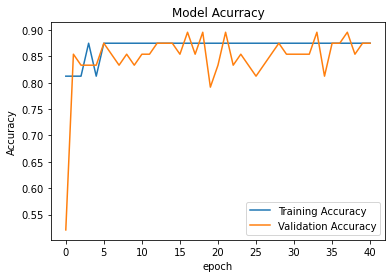

In [22]:
plt.plot(history.history['val_soft_acc'])
plt.plot(history.history['soft_acc'])
plt.title('Model Acurracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.show()

In [23]:
tf = x_test[:,19]
tf

array([[0.82978723, 0.76653696, 0.89952153, 0.23483657]])

In [24]:
# scaler.inverse_transform(v)를 돌리기 위해 pred가 들어간 (1,5)를 만들어줍니다 
# tf는 형식 때문에 들어갔기 때문에 중요하게 취급되는 값이 아닙니다

arr_1D = np.insert(tf, 3, pred)

# scaler.inverse_transform(v)를 돌리기 위해 array를 2D로 바꿔줍니다

arr_2D = arr_1D.reshape((1,-1))

arr_2D

array([[0.82978723, 0.76653696, 0.89952153, 0.708794  , 0.23483657]])

In [25]:
sit_arr_2D = scaler.inverse_transform(arr_2D)
sit_arr_2D

array([[ 10100.        ,  10200.        ,   9940.        ,
          9919.07293439, 133504.        ]])

In [26]:
predict_HY = sit_arr_2D[:,3]

predict_HY

array([9919.07293439])

In [27]:
# 21일 중 20일을 학습시켜 얻은 21-02-05의 예측주가입니다(2/5 종가 확정 후 검사)

prediction = int(predict_HY[[0]])
print('Predicted value for next day=',prediction, '원')
b = df['Close'].iloc[-1]
print('Last close price=',b, '원')
percentage = ((prediction-b)/b)*100
print('percentage change should be =', percentage.round(3),'%' )

Predicted value for next day= 9919 원
Last close price= 10650 원
percentage change should be = -6.864 %


In [28]:
accuracy_train = 100*score_train[1]
accuracy_validation = 100*score_validation[1]

print('train accuracy: %.4f%%' % accuracy_train)
print('validation accuracy: %.4f%%' % accuracy_validation)

train accuracy: 87.5000%
validation accuracy: 87.5000%


In [29]:
import numpy as np
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error

Y = np.asarray(y_test)
Y_hat = pred

def MSE(y_true, y_pred):
    return np.mean(np.square((y_true - y_pred)))

def MAE(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred)))

def RMSE(y_true, y_pred):
    return np.sqrt(np.mean((y_pred-y_true)**2))

def MAPE(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def MPE(y_true, y_pred): 
    return np.mean((y_true - y_pred) / y_true) * 100

def root_mean_squared_log_error(y_true, y_pred): 
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

print('R2_Score')
print('-' * 40)
print('train error: {} |\nvalid error: {} |\ntest error : {}\n'.format(score_train[9], score_validation[9], r2_score(Y, Y_hat)))

print('Mean Squared Error')
print('-' * 40)
print('train error: {} |\nvalid error: {} |\ntest error : {}\n'.format(score_train[2], score_validation[2], MSE(Y, Y_hat)))

print('Mean Absolute Error')
print('-' * 40)
print('train error: {} |\nvalid error: {} |\ntest error : {}\n'.format(score_train[3], score_validation[3], MAE(Y, Y_hat)))

print('Root Mean Squared Error')
print('-' * 40)
print('train error: {} |\nvalid error: {} |\ntest error : {}\n'.format(score_train[4], score_validation[3], RMSE(Y, Y_hat)))

print('Mean Squared Logarithmic Error')
print('-' * 40)
print('train error: {} |\nvalid error: {} |\ntest error : {}\n'.format(score_train[7], score_validation[7], mean_squared_log_error(Y, Y_hat)))

print('Root Mean Squared Logarithmic Error')
print('-' * 40)
print('train error: {} |\nvalid error: {} |\ntest error : {}\n'.format(score_train[8], score_validation[8], root_mean_squared_log_error(Y, Y_hat)))

print('Mean Absolute Percentage Error')
print('-' * 40)
print('train error: {} |\nvalid error: {} |\ntest error : {}\n'.format(score_train[5], score_validation[3], MAPE(Y, Y_hat)))

print('Mean Percentage Error')
print('-' * 40)
print('train error: {} |\nvalid error: {} |\ntest error : {}\n'.format(score_train[6], score_validation[3], MPE(Y, Y_hat)))


R2_Score
----------------------------------------
train error: -13.811051368713379 |
valid error: -0.8002797365188599 |
test error : nan

Mean Squared Error
----------------------------------------
train error: 0.004828365053981543 |
valid error: 0.0034562796354293823 |
test error : 0.08480093573793086

Mean Absolute Error
----------------------------------------
train error: 0.053121794015169144 |
valid error: 0.050891272723674774 |
test error : 0.29120600223541215

Root Mean Squared Error
----------------------------------------
train error: 0.05984004959464073 |
valid error: 0.050891272723674774 |
test error : 0.29120600223541215

Mean Squared Logarithmic Error
----------------------------------------
train error: 0.0023160281125456095 |
valid error: 0.001777402125298977 |
test error : 0.02476194934031779

Root Mean Squared Logarithmic Error
----------------------------------------
train error: 0.036562588065862656 |
valid error: 0.03545112907886505 |
test error : 0.1573593001392602

C:\ProgramData\Anaconda3\envs\tensorflow-cpu\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [30]:
# count : 개수, std : 표준편차

test[label_cols].describe()

,Close
count,21.000000
mean,0.631948
std,0.148987
min,0.446215
25%,0.533865
50%,0.609562
75%,0.737052
max,1.000000
